In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine 
import random
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, r2_score, precision_score, confusion_matrix
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV


import torch
import torch.nn as nn
from math import ceil

In [2]:
pd.set_option('display.float_format', '{:.4f}'.format)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

In [4]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string) 

## Подключитесь к базе. Загрузите таблицы sql

In [6]:
query_case = '''
SELECT *
FROM case_ids
LIMIT 10
;
'''

sample_case = pd.read_sql_query(query_case, con=engine)

In [7]:
query_collisions = '''
SELECT *
FROM collisions
LIMIT 10
;
'''

sample_collisions = pd.read_sql_query(query_collisions, con=engine)
sample_collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0000,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0000,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0000,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0000,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0000,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [8]:
query_Parties = '''
SELECT *
FROM Parties
LIMIT 10
;
'''

sample_Parties = pd.read_sql_query(query_Parties, con=engine)
sample_Parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0000,had not been drinking,None,0.0000
1,23,3899454,2,road signs,0,7.0000,had not been drinking,None,0.0000
2,29,3899462,2,car,0,21.0000,had not been drinking,None,0.0000
3,31,3899465,2,road signs,0,24.0000,had not been drinking,None,0.0000
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0000


In [9]:
query_Vehicles = '''
SELECT *
FROM Vehicles
LIMIT 10
;
'''

sample_Vehicles = pd.read_sql_query(query_Vehicles, con=engine)
sample_Vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


## Проведите первичное исследование таблиц

**Все ли таблицы имеют набор данных;**
* Соответствует ли количество таблиц условию задачи;
* Имеется ли общий ключ для связи таблиц.
* Для осмотра таблиц используйте sql-запрос.

In [10]:
display( sample_case.head() )

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [11]:
display( sample_collisions.head() ) 

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0000,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0000,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0000,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0000,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0000,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [12]:
display( sample_Parties.head() ) 

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0000,had not been drinking,None,0.0000
1,23,3899454,2,road signs,0,7.0000,had not been drinking,None,0.0000
2,29,3899462,2,car,0,21.0000,had not been drinking,None,0.0000
3,31,3899465,2,road signs,0,24.0000,had not been drinking,None,0.0000
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0000


In [13]:
display( sample_Vehicles.head() )

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


* Общий ключь для связи всех таблиц case_id

##  Проведите статистический анализ факторов ДТП

Шаг 3. Проведите статистический анализ факторов ДТП
1. Выясните, в какие месяцы происходит наибольшее количество аварий. Проанализируйте весь период наблюдений (таблица collisions).
    Создайте sql-запрос;
    Постройте график;
    Сделайте вывод.

2. Скоро состоится первое совещание вашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого вы должны создать подходящие аналитические задачи и поручить их решение коллегам. Примеры задач:
Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);
    
* Найдите самые частые причины ДТП (таблица parties).
* 2.1. Создайте не менее шести задач для коллег. Опирайтесь на примеры и таблицы. 
* 2.2. Пропишите порядок решения для двух задач из списка. Обязательное условие — решение этих задач должно включать связь не менее 2-х таблиц. Пример прописанного порядка:
Создайте sql-запрос;
Постройте график;
Сделайте вывод.

### Анализ количества ДТП по месяцам

In [14]:
query_dtp = '''
SELECT
    TO_CHAR( COLLISION_DATE, 'MM' ),
    COUNT( CASE_ID )
FROM collisions
GROUP BY TO_CHAR( COLLISION_DATE, 'MM' )
ORDER BY TO_CHAR( COLLISION_DATE, 'MM' )
;
'''

month_dtp = pd.read_sql_query(query_dtp, con=engine)
month_dtp['count'].sum()

1400000

In [15]:
query_dtp_2012 = '''
SELECT
    TO_CHAR( COLLISION_DATE, 'MM' ),
    COUNT( CASE_ID )
FROM collisions
WHERE 
    DATE_TRUNC('year', COLLISION_DATE::timestamp) > '31.12.2011'
    AND DATE_TRUNC('year', COLLISION_DATE::timestamp) < '01.01.2013'
GROUP BY TO_CHAR( COLLISION_DATE, 'MM' )
ORDER BY TO_CHAR( COLLISION_DATE, 'MM' )
;
'''

month_dtp_2012 = pd.read_sql_query(query_dtp_2012, con=engine)

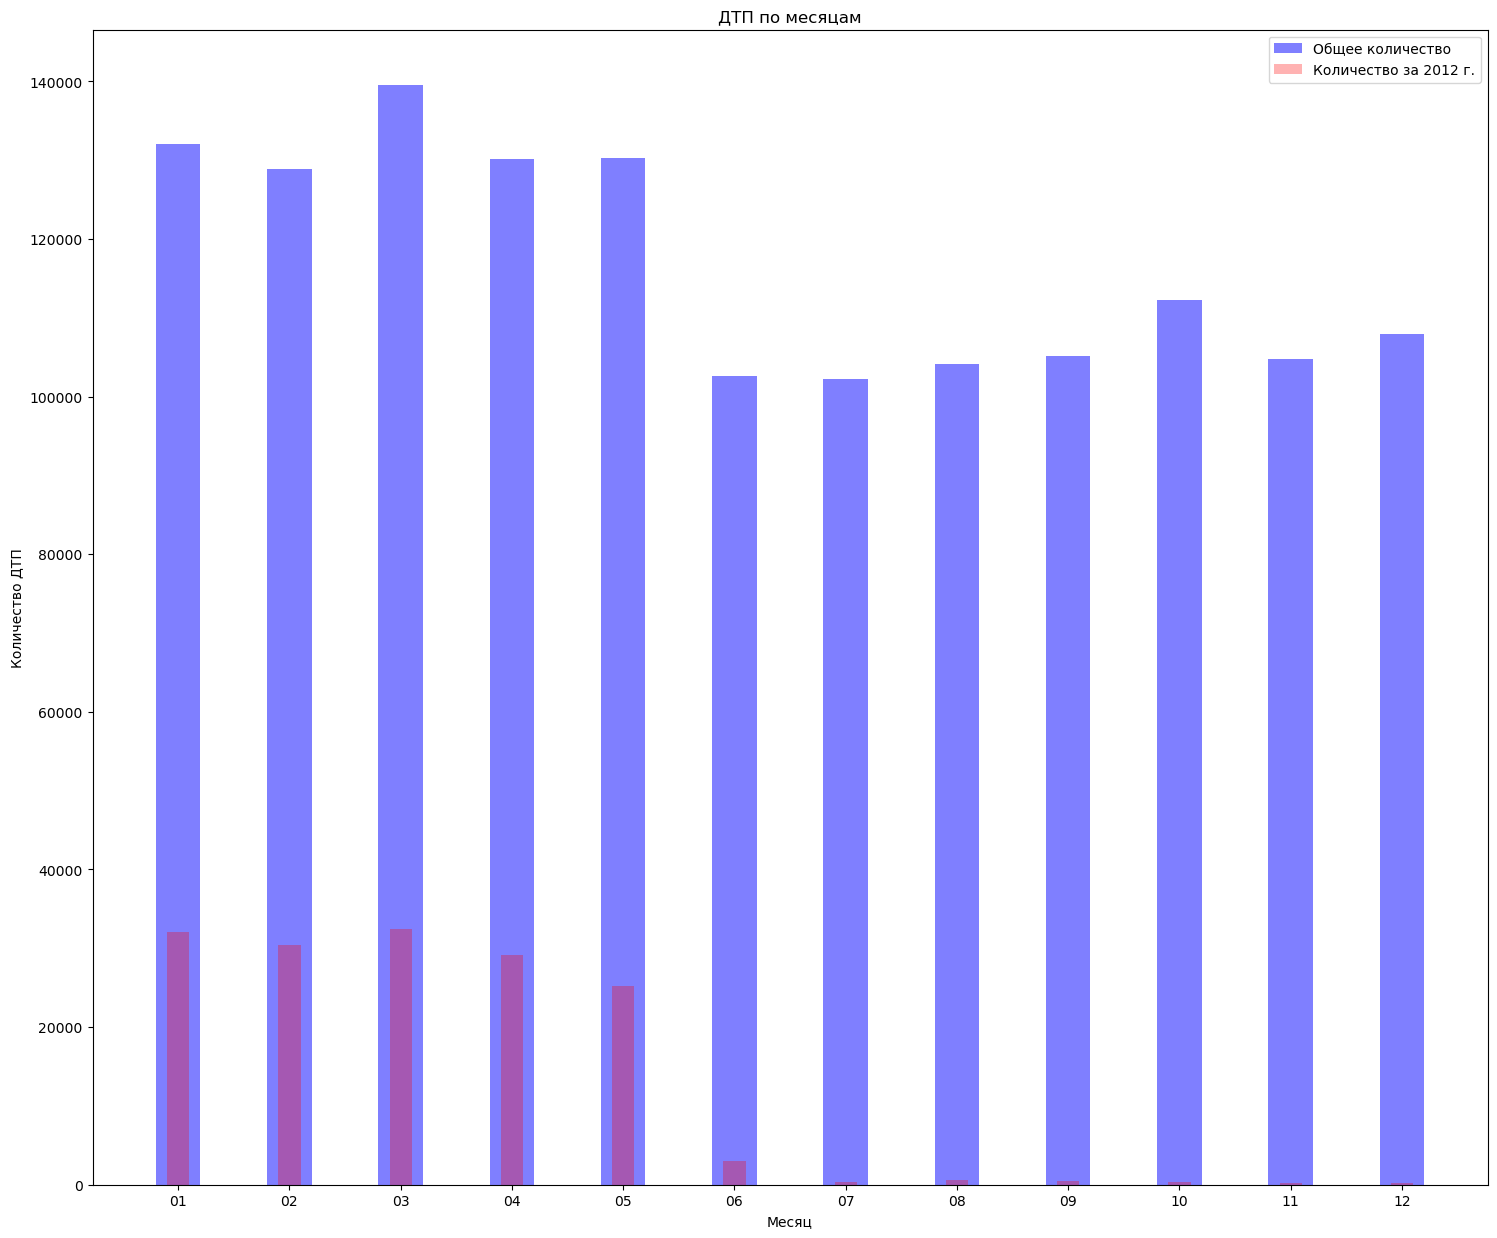

In [16]:
x = month_dtp['to_char']
y = month_dtp['count']
z = month_dtp_2012['count']

fig, ax = plt.subplots(figsize = (18, 15))

bar_f = plt.bar(x, y, color='b', label='Общее количество', width = 0.4, alpha=0.5)

bar_p = plt.bar(x, z, color='r', label='Количество за 2012 г.', width = 0.2, alpha=0.3)

plt.legend()

plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.title('ДТП по месяцам')
plt.show()

* Количество ДТП резко возростает с января по май
* Распределение за 2012 год совпадает

### Аналитические задачи

2. Скоро состоится первое совещание вашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого вы должны создать подходящие аналитические задачи и поручить их решение коллегам. Примеры задач:
Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);
    
* Найдите самые частые причины ДТП (таблица parties).
* 2.1. Создайте не менее шести задач для коллег. Опирайтесь на примеры и таблицы. 
* 2.2. Пропишите порядок решения для двух задач из списка. Обязательное условие — решение этих задач должно включать связь не менее 2-х таблиц. Пример прописанного порядка:
Создайте sql-запрос;
Постройте график;
Сделайте вывод.

#### 1

* Проведите анализ серьёзности повреждений транспортного средства, исходя из состояние участника ДТП (связать collisions и parties);

**Порядок решения**
* Создайте sql-запрос; Постройте график; Сделайте вывод.

In [17]:
query_1 = '''
WITH tab_p AS(
    SELECT
        PARTY_SOBRIETY,
        id,
        CASE_ID AS case_id_p
    FROM parties), 

tab_c AS(
    SELECT
        COLLISION_DAMAGE,
        CASE_ID AS case_id_c
    FROM collisions),
    
tab_un AS(
    SELECT
        *        
    FROM tab_p AS p
    FULL OUTER JOIN tab_c AS c ON p.case_id_p=c.case_id_c
    )  
    
SELECT
    party_sobriety,
    COLLISION_DAMAGE,
    COUNT(id)
FROM tab_un
GROUP BY party_sobriety, COLLISION_DAMAGE
;
'''

df_1 = pd.read_sql_query(query_1, con=engine)
df_1 = df_1.fillna('unk')
df_1

,party_sobriety,collision_damage,count
0,"had been drinking, not under influence",small damage,8961
1,not applicable,middle damage,15340
2,"had been drinking, impairment unknown",fatal,436
3,had not been drinking,middle damage,248863
4,impairment unknown,small damage,178020
5,"had been drinking, impairment unknown",small damage,14295
6,"had been drinking, not under influence",middle damage,3167
7,impairment unknown,severe damage,4384
8,"had been drinking, not under influence",severe damage,711
9,impairment unknown,scratch,34345


##### 'had been drinking, impairment unknown' (Был пьян, ухудшение неизвестно)

(-1.1045125391403812,
 1.1947870289359777,
 -1.0999999045230255,
 1.099998896187417)

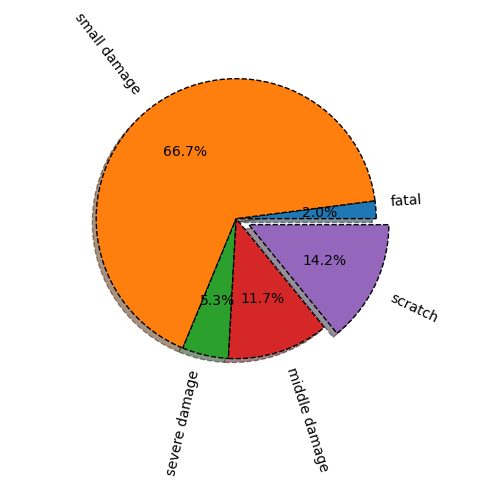

In [18]:
collision_damage = df_1['collision_damage'][df_1['party_sobriety'] == 'had been drinking, impairment unknown']
 
count = df_1['count'][df_1['party_sobriety'] == 'had been drinking, impairment unknown']
 
explode = (0, 0, 0, 0, 0.1)

fig, ax = plt.subplots(figsize =(6, 4))
ax.pie(count, labels=collision_damage, autopct='%1.1f%%', explode=explode, shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)

ax.axis("equal")

##### 'had been drinking, not under influence' (Был пьян, не под влиянием)

(-1.103516248588573,
 1.1738420583880147,
 -1.1746481747907382,
 1.103554668906554)

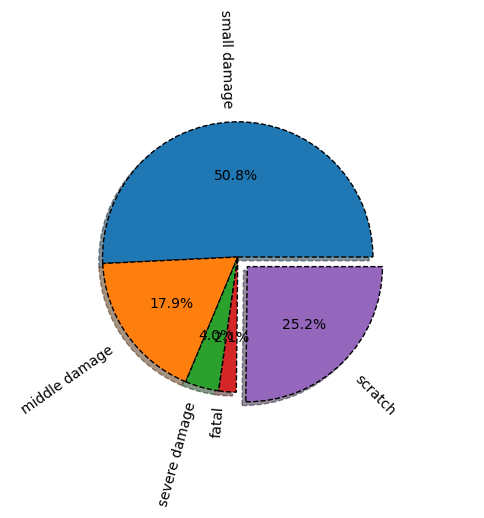

In [19]:
collision_damage = df_1['collision_damage'][df_1['party_sobriety'] == 'had been drinking, not under influence']
 
count = df_1['count'][df_1['party_sobriety'] == 'had been drinking, not under influence']
 
explode = (0, 0, 0, 0, 0.1)

fig, ax = plt.subplots(figsize =(6, 4))
ax.pie(count, labels=collision_damage, autopct='%1.1f%%', explode=explode, shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)

ax.axis("equal")

##### 'had been drinking, under influence'  (Был пьян, под влиянием)

(-1.1049270088976262,
 1.2034774149097485,
 -1.099999544212364,
 1.099999380386641)

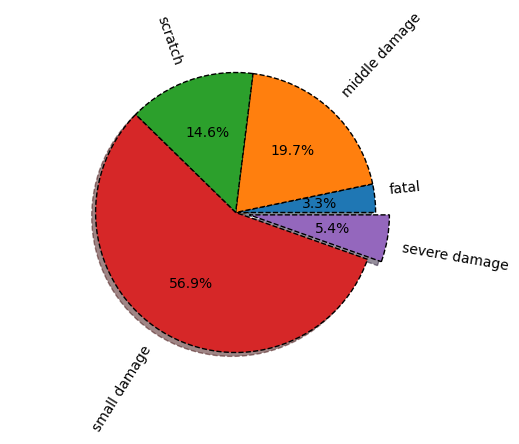

In [20]:
collision_damage = df_1['collision_damage'][df_1['party_sobriety'] == 'had been drinking, under influence']
 
count = df_1['count'][df_1['party_sobriety'] == 'had been drinking, under influence']
 
explode = (0, 0, 0, 0, 0.1)

fig, ax = plt.subplots(figsize =(6, 4))
ax.pie(count, labels=collision_damage, autopct='%1.1f%%', explode=explode, shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)

ax.axis("equal")

##### 'had not been drinking' (Не пил)

(-1.1190074206244853,
 1.1009051152678326,
 -1.2032643456542012,
 1.1049159313053667)

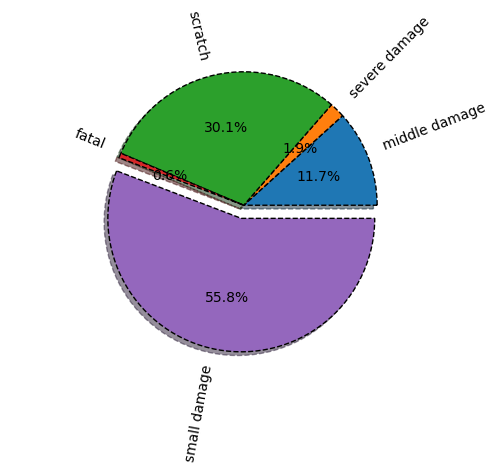

In [21]:
collision_damage = df_1['collision_damage'][df_1['party_sobriety'] == 'had not been drinking']
 
count = df_1['count'][df_1['party_sobriety'] == 'had not been drinking']
 
explode = (0, 0, 0, 0, 0.1)

fig, ax = plt.subplots(figsize =(6, 4))
ax.pie(count, labels=collision_damage, autopct='%1.1f%%', explode=explode, shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)

ax.axis("equal")

##### 'impairment unknown' (Неизвестно ухудшение)

(-1.1049074224447064,
 1.203057814218669,
 -1.0999999425146694,
 1.0999999630123194)

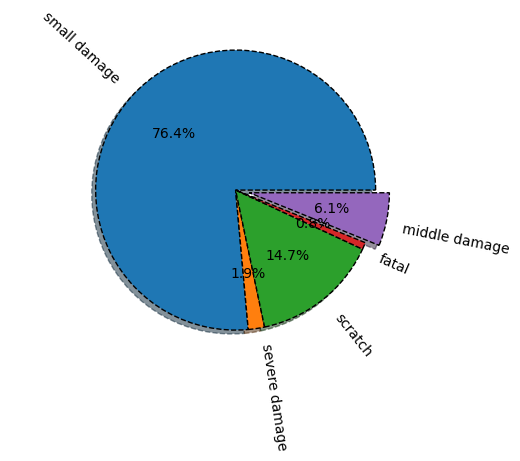

In [22]:
collision_damage = df_1['collision_damage'][df_1['party_sobriety'] == 'impairment unknown']
 
count = df_1['count'][df_1['party_sobriety'] == 'impairment unknown']
 
explode = (0, 0, 0, 0, 0.1)

fig, ax = plt.subplots(figsize =(6, 4))
ax.pie(count, labels=collision_damage, autopct='%1.1f%%', explode=explode, shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)

ax.axis("equal")

##### 'not applicable' (Не оценивался)

(-1.177685564926123, 1.1036993126155297, -1.1704143030435, 1.0986353861997666)

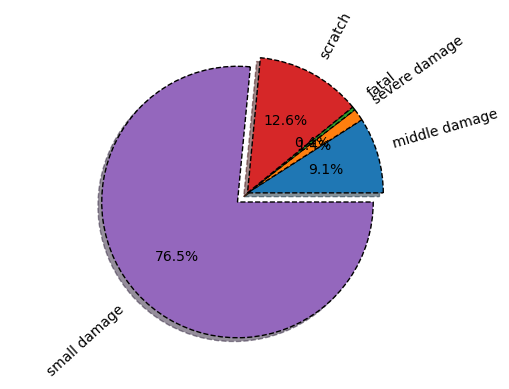

In [23]:
collision_damage = df_1['collision_damage'][df_1['party_sobriety'] == 'not applicable']
 
count = df_1['count'][df_1['party_sobriety'] == 'not applicable']
 
explode = (0, 0, 0, 0, 0.1)

fig, ax = plt.subplots(figsize =(6, 4))
ax.pie(count, labels=collision_damage, autopct='%1.1f%%', explode=explode, shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)

ax.axis("equal")

##### 'unk' (нет информации)

(-1.1380697154420398,
 1.101812843592478,
 -1.1978542085304453,
 1.1046597242156748)

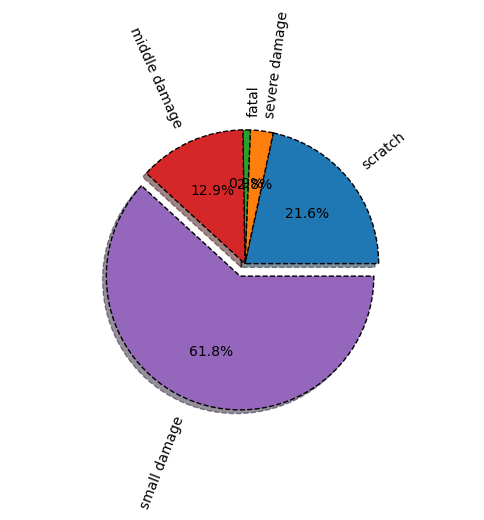

In [24]:
collision_damage = df_1['collision_damage'][df_1['party_sobriety'] == 'unk']
 
count = df_1['count'][df_1['party_sobriety'] == 'unk']
 
explode = (0, 0, 0, 0, 0.1)

fig, ax = plt.subplots(figsize =(6, 4))
ax.pie(count, labels=collision_damage, autopct='%1.1f%%', explode=explode, shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)

ax.axis("equal")

##### Общий график

[Text(0, 0, 'had been drinking, not under influence'),
 Text(1, 0, 'not applicable'),
 Text(2, 0, 'had been drinking, impairment unknown'),
 Text(3, 0, 'had not been drinking'),
 Text(4, 0, 'impairment unknown'),
 Text(5, 0, 'unk'),
 Text(6, 0, 'had been drinking, under influence')]

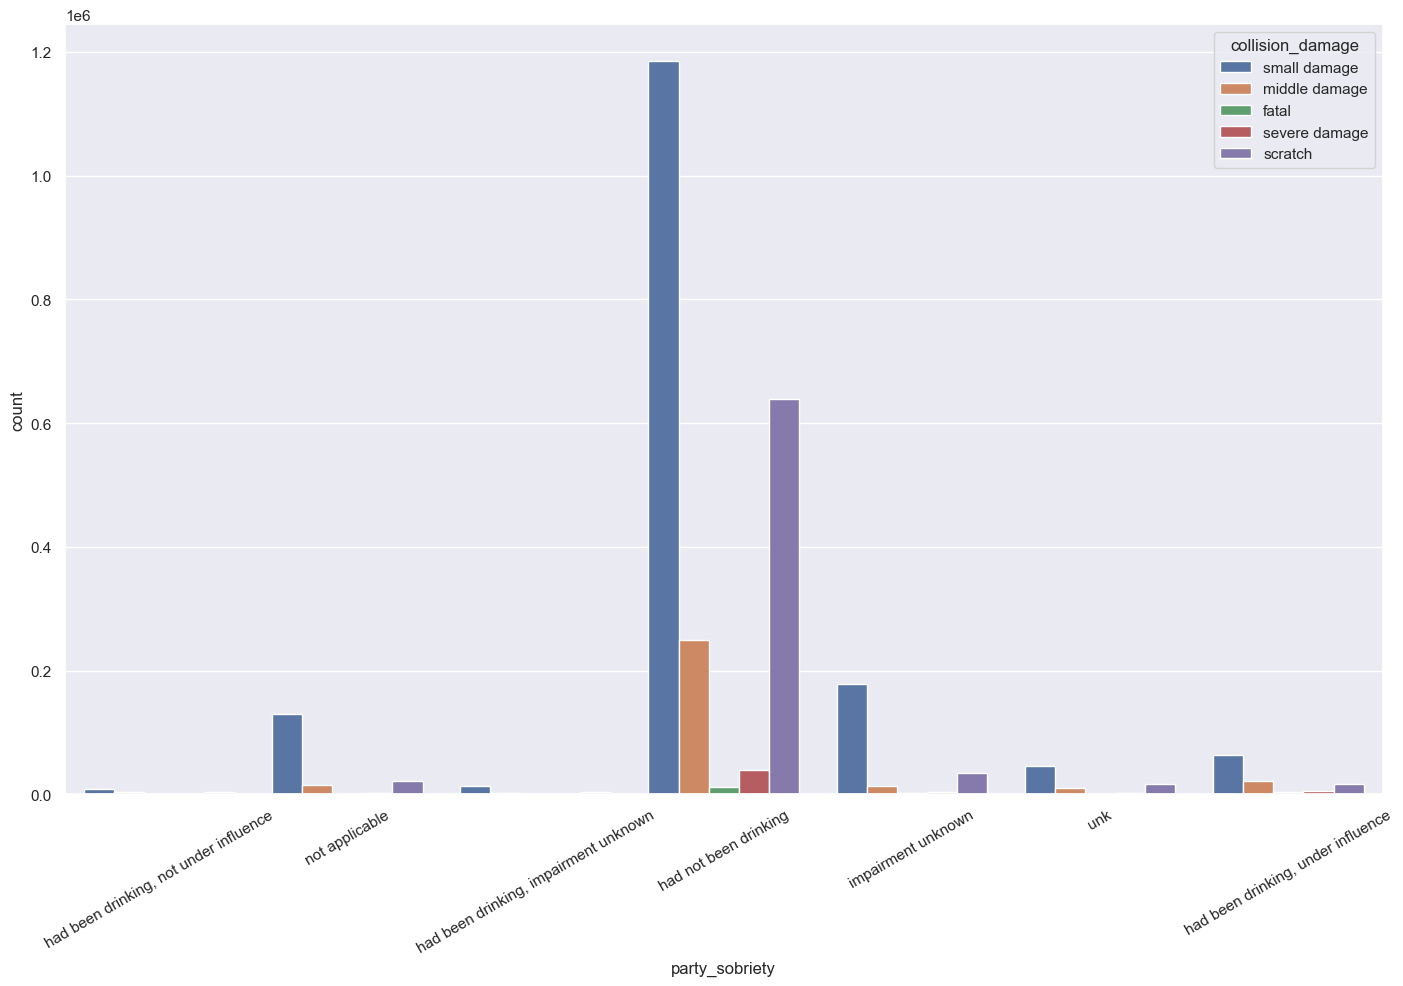

In [25]:
sns.set(rc={'figure.figsize':(17,10)})
ax = sns.barplot(data=df_1, x="party_sobriety", y="count", hue="collision_damage")

ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)


##### Вывод

* У участника ДТП который небыл пьян самый высокий шанс получить самые легкие повреждения авто (scratch)
* Среди всех повреждений авто наиболее часто встречающееся это 'small damage'
* Вероятность, что авто водителя который был пьян получит повреждение типа 'fatal' и 'severe damage' значительно выше чем у других водителей

#### 2

* Проведите анализ типа аварии, исходя из наличия телефона в автомобиле (возможности разговаривать по громкой связи) (связать collisions и parties);

**Порядок решения**
* Создайте sql-запрос; Постройте график; Сделайте вывод.

In [26]:
query_2 = '''
WITH tab_p AS(
    SELECT
        CELLPHONE_IN_USE,
        id,
        CASE_ID AS case_id_p
    FROM parties), 

tab_c AS(
    SELECT
        TYPE_OF_COLLISION,
        CASE_ID AS case_id_c
    FROM collisions),
    
tab_un AS(
    SELECT
        *        
    FROM tab_p AS p
    FULL OUTER JOIN tab_c AS c ON p.case_id_p=c.case_id_c
    )  
    
SELECT
    TYPE_OF_COLLISION,
    CELLPHONE_IN_USE,
    COUNT(id)
FROM tab_un
GROUP BY CELLPHONE_IN_USE, TYPE_OF_COLLISION
ORDER BY type_of_collision, cellphone_in_use
;
'''

df_2 = pd.read_sql_query(query_2, con=engine)
df_2 = df_2.dropna(axis=0)
df_2

,type_of_collision,cellphone_in_use,count
0,broadside,0.0000,439654
1,broadside,1.0000,6999
3,head-on,0.0000,83574
4,head-on,1.0000,1417
6,hit object,0.0000,221626
7,hit object,1.0000,5344
9,other,0.0000,103889
10,other,1.0000,2040
12,overturned,0.0000,39769
13,overturned,1.0000,763


##### cellphone_in_use = 1

(-1.185543707296087,
 1.1040735098712422,
 -1.1608710216287819,
 1.102898599449479)

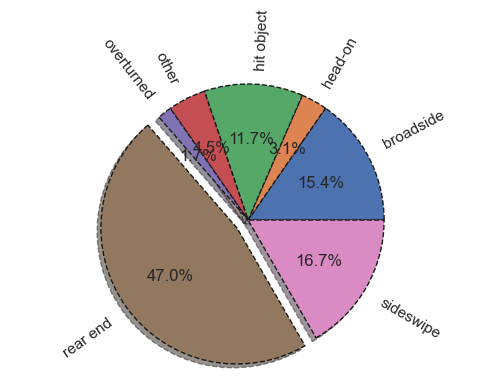

In [27]:
type_of_collision = df_2['type_of_collision'][df_2['cellphone_in_use'] == 1]
 
count = df_2['count'][df_2['cellphone_in_use'] == 1]
 
explode = (0, 0, 0, 0, 0, 0.1, 0)

fig, ax = plt.subplots(figsize =(6, 4))
ax.pie(count, labels=type_of_collision, autopct='%1.1f%%', explode=explode, shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)

ax.axis("equal")

##### cellphone_in_use = 0

(-1.178600797037879,
 1.1037428950970418,
 -1.1696133538795899,
 1.103314886118214)

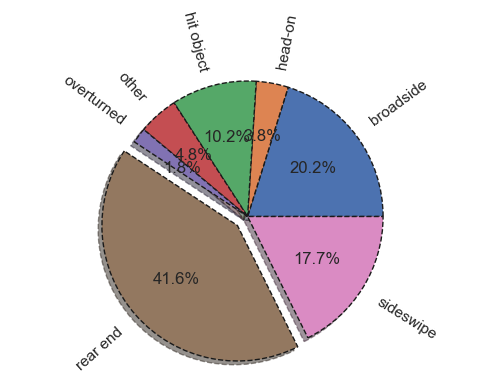

In [28]:
type_of_collision = df_2['type_of_collision'][df_2['cellphone_in_use'] == 0]
 
count = df_2['count'][df_2['cellphone_in_use'] == 0]
 
explode = (0, 0, 0, 0, 0, 0.1, 0)

fig, ax = plt.subplots(figsize =(6, 4))
ax.pie(count, labels=type_of_collision, autopct='%1.1f%%', explode=explode, shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)

ax.axis("equal")

##### Вывод

* При cellphone_in_use = 1 количество ДТП типа 'rear end' больше на 6%
* При cellphone_in_use = 1 количество ДТП типа 'broadside' больше на 5%
* В остальном распределение практически идентично

#### 3

* Проведите анализ времени происшествия, исходя из трезвости участника ДТП (связать collisions и parties);

#### 4

* Проведите анализ наличия телефона в автомобиле (возможности разговаривать по громкой связи), исходя из типа КПП авто (связать Vehicles и parties);

#### 5

* Проведите анализ погоды во время ДТП, исходя из типа участника происшествия (связать collisions и parties);

#### 6

* Проведите анализ серьёзности повреждений транспортного средства, исходя из типа участника происшествия (связать collisions и parties);

## Создайте модель для оценки водительского риска

### Подготовка набора данных на основе первичного предположения заказчика

* тип виновника — только машина (car). 
* случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
* данные только за 2012 год.

**Parties**
* PARTY_DRUG_PHYSICAL - Например если водитель принял лекарство которое вызывает сонливость вероятность ДТП возрастает
* PARTY_SOBRIETY - Если водитель пьян вероятность ДТП выше
* INSURANCE_PREMIUM - Возможно чем больше тем менее акуратно водит водитель
* CELLPHONE_IN_USE - Есле есть телефон в машине то вероятность, что водитель отвлечется выше

**Vehicles**
* VEHICLE_AGE - Чем старше авто тем больше вероятность поломок и как следствие ДТП
* VEHICLE_TRANSMISSION - Пока незнаю 

In [29]:
query_df = '''
WITH a AS(
    SELECT
        CASE_id AS c_id_c
    FROM collisions 
    WHERE COLLISION_DATE > '31.12.2011'
        AND COLLISION_DATE < '01.01.2013' 
        AND COLLISION_DAMAGE != 'scratch' ),
        
b AS(
    SELECT
        CASE_id AS c_id_p
    FROM Parties
    WHERE PARTY_TYPE = 'car'
        AND at_fault = 1 ),
    
id AS(
    SELECT
        c_id_c
    FROM a AS a
    INNER JOIN b AS b ON b.c_id_p = a.c_id_c ),
    
Vehicles AS(
    SELECT
        CASE_id AS c_id_v,
        party_number AS pn_v,
        VEHICLE_AGE,
        VEHICLE_TRANSMISSION
    FROM Vehicles ),
    
Parties AS(
    SELECT
        CASE_id AS c_id_f,
        party_number AS pn_p,
        PARTY_DRUG_PHYSICAL,
        PARTY_SOBRIETY,
        INSURANCE_PREMIUM,
        CELLPHONE_IN_USE,
        at_fault
    FROM Parties),
    
pre_final AS(
    SELECT
        *
    FROM id AS i 
    LEFT OUTER JOIN Parties AS p ON i.c_id_c = p.c_id_f ),
    
final AS(
    SELECT
        *
    FROM pre_final AS pre 
    LEFT OUTER JOIN Vehicles AS v ON pre.c_id_c = v.c_id_v AND pre.pn_p=v.pn_v )


SELECT
    *
FROM final
'''

df = pd.read_sql_query(query_df, con=engine)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198481 entries, 0 to 198480
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   c_id_c                198481 non-null  object 
 1   c_id_f                198481 non-null  object 
 2   pn_p                  198481 non-null  int64  
 3   party_drug_physical   34923 non-null   object 
 4   party_sobriety        193277 non-null  object 
 5   insurance_premium     165463 non-null  float64
 6   cellphone_in_use      167112 non-null  float64
 7   at_fault              198481 non-null  int64  
 8   c_id_v                55616 non-null   object 
 9   pn_v                  55616 non-null   float64
 10  vehicle_age           54027 non-null   float64
 11  vehicle_transmission  54762 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 18.2+ MB


In [30]:
df.head()

,c_id_c,c_id_f,pn_p,party_drug_physical,party_sobriety,insurance_premium,cellphone_in_use,at_fault,c_id_v,pn_v,vehicle_age,vehicle_transmission
0,5541986,5541986,4,None,had not been drinking,41.0000,0.0000,0,5541986,4.0000,7.0000,manual
1,5623284,5623284,4,None,had not been drinking,25.0000,0.0000,0,None,NaN,NaN,None
2,5631582,5631582,4,not applicable,not applicable,NaN,NaN,0,None,NaN,NaN,None
3,5517917,5517917,4,None,None,NaN,NaN,0,None,NaN,NaN,None
4,5543780,5543780,4,None,had not been drinking,34.0000,1.0000,0,5543780,4.0000,5.0000,auto


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198481 entries, 0 to 198480
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   c_id_c                198481 non-null  object 
 1   c_id_f                198481 non-null  object 
 2   pn_p                  198481 non-null  int64  
 3   party_drug_physical   34923 non-null   object 
 4   party_sobriety        193277 non-null  object 
 5   insurance_premium     165463 non-null  float64
 6   cellphone_in_use      167112 non-null  float64
 7   at_fault              198481 non-null  int64  
 8   c_id_v                55616 non-null   object 
 9   pn_v                  55616 non-null   float64
 10  vehicle_age           54027 non-null   float64
 11  vehicle_transmission  54762 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 18.2+ MB


In [32]:
df = df.drop(columns = ['c_id_f', 'pn_p', 'pn_v', 'c_id_v'] )

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198481 entries, 0 to 198480
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   c_id_c                198481 non-null  object 
 1   party_drug_physical   34923 non-null   object 
 2   party_sobriety        193277 non-null  object 
 3   insurance_premium     165463 non-null  float64
 4   cellphone_in_use      167112 non-null  float64
 5   at_fault              198481 non-null  int64  
 6   vehicle_age           54027 non-null   float64
 7   vehicle_transmission  54762 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 12.1+ MB


,c_id_c,party_drug_physical,party_sobriety,insurance_premium,cellphone_in_use,at_fault,vehicle_age,vehicle_transmission
0,5541986,None,had not been drinking,41.0000,0.0000,0,7.0000,manual
1,5623284,None,had not been drinking,25.0000,0.0000,0,NaN,None
2,5631582,not applicable,not applicable,NaN,NaN,0,NaN,None
3,5517917,None,None,NaN,NaN,0,NaN,None
4,5543780,None,had not been drinking,34.0000,1.0000,0,5.0000,auto


### Анализ

#### party_drug_physical - Состояние участника: физическое или с учётом принятых лекарств

* В колонке party_drug_physical есть значение - Impairment Unknown. Логично пропуски заменить этим значением.

In [33]:
df['party_drug_physical'] = df['party_drug_physical'].fillna('Impairment Unknown')
df['party_drug_physical'] = df['party_drug_physical'].replace('G', 'Impairment Unknown')

In [34]:
display ( df.pivot_table(index = ['party_drug_physical', 'at_fault'], values = 'c_id_c', aggfunc = ['count'])\
    .sort_values(by = ('party_drug_physical'), ascending = False) )

count
                               c_id_c
party_drug_physical   at_fault       
under drug influence  0           110
                      1          1406
sleepy/fatigued       0            14
                      1          1058
not applicable        0         12652
                      1           806
impairment - physical 0             9
                      1           155
Impairment Unknown    0         82649
                      1         99622

* Зависимость между состоянием и виновностью подтвердилась

#### vehicle_transmission - Тип КПП

In [35]:
df['vehicle_transmission'].value_counts()

vehicle_transmission
manual    29385
auto      25377
Name: count, dtype: int64

In [36]:
df['vehicle_transmission'] = df['vehicle_transmission'].fillna('unk')

In [37]:
display ( df.pivot_table(index = ['vehicle_transmission', 'at_fault'], values = 'c_id_c', aggfunc = ['count'])\
    .sort_values(by = ('vehicle_transmission'), ascending = False) )

count
                              c_id_c
vehicle_transmission at_fault       
unk                  0         68626
                     1         75093
manual               0         13303
                     1         16082
auto                 0         13505
                     1         11872

* Связи между vehicle_transmission и at_fault - нет. Колонку vehicle_transmission лучше удалить

In [38]:
df = df.drop(columns = ['vehicle_transmission'] )

In [39]:
df.columns

Index(['c_id_c', 'party_drug_physical', 'party_sobriety', 'insurance_premium',
       'cellphone_in_use', 'at_fault', 'vehicle_age'],
      dtype='object')

#### cellphone_in_use - Наличие телефона в автомобиле (возможности разговаривать по громкой связи)

In [40]:
df['cellphone_in_use'].value_counts()

cellphone_in_use
0.0000    163183
1.0000      3929
Name: count, dtype: int64

In [41]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna('unk')

In [42]:
display ( df.pivot_table(index = ['cellphone_in_use', 'at_fault'], values = 'c_id_c', aggfunc = ['count']) )#\
    #.sort_values(by = ('cellphone_in_use'), ascending = False) )

count
                          c_id_c
cellphone_in_use at_fault       
0.0              0         78029
                 1         85154
1.0              0          1671
                 1          2258
unk              0         15734
                 1         15635

* Связи между cellphone_in_use и at_fault - нет. Колонку cellphone_in_use лучше удалить

In [43]:
df = df.drop(columns = ['cellphone_in_use'] )

In [44]:
df.columns

Index(['c_id_c', 'party_drug_physical', 'party_sobriety', 'insurance_premium',
       'at_fault', 'vehicle_age'],
      dtype='object')

#### party_sobriety - Трезвость участника

In [45]:
df['party_sobriety'].value_counts()

party_sobriety
had not been drinking                     148138
impairment unknown                         18713
not applicable                             13458
had been drinking, under influence         10139
had been drinking, impairment unknown       1550
had been drinking, not under influence      1279
Name: count, dtype: int64

* В колонке party_sobriety есть значение - not applicable. Логично пропуски заменить этим значением.

In [46]:
df['party_sobriety'] = df['party_sobriety'].fillna('not applicable')

In [47]:
display ( df.pivot_table(index = ['party_sobriety', 'at_fault'], values = 'c_id_c', aggfunc = ['count'])\
    .sort_values(by = ('party_sobriety'), ascending = False) )

count
                                                c_id_c
party_sobriety                         at_fault       
not applicable                         0         15498
                                       1          3164
impairment unknown                     0          1769
                                       1         16944
had not been drinking                  0         77432
                                       1         70706
had been drinking, under influence     0           309
                                       1          9830
had been drinking, not under influence 0           307
                                       1           972
had been drinking, impairment unknown  0           119
                                       1          1431

* Зависимость между party_sobriety	и at_fault подтвердилась

#### vehicle_age - Возраст автомобиля (в годах)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198481 entries, 0 to 198480
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   c_id_c               198481 non-null  object 
 1   party_drug_physical  198481 non-null  object 
 2   party_sobriety       198481 non-null  object 
 3   insurance_premium    165463 non-null  float64
 4   at_fault             198481 non-null  int64  
 5   vehicle_age          54027 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.1+ MB


In [49]:
display( df['vehicle_age'].describe() )

count   54027.0000
mean        4.8742
std         3.2375
min         0.0000
25%         3.0000
50%         4.0000
75%         7.0000
max       161.0000
Name: vehicle_age, dtype: float64

In [50]:
df['vehicle_age'] = df['vehicle_age'].fillna('unk')

In [51]:
display ( df.pivot_table(index = ['vehicle_age', 'at_fault'], values = 'c_id_c', aggfunc = ['count']) ) 

count
                     c_id_c
vehicle_age at_fault       
0.0         0          1630
            1          1358
1.0         0          1367
            1          1073
2.0         0          2669
            1          3413
3.0         0          4076
            1          6807
4.0         0          3322
            1          3755
5.0         0          2880
            1          2581
6.0         0          2179
            1          1748
7.0         0          2083
            1          1743
8.0         0          2038
            1          1462
9.0         0          1591
            1          1188
10.0        0          1118
            1           827
11.0        0           713
            1           647
12.0        0           420
            1           443
13.0        0           259
            1           299
14.0        0           122
            1           162
15.0        0            12
            1            29
16.0        0             5
            1             2
17.0        0             1
            1             2
19.0        1             1
161.0       0             1
            1             1
unk         0         68948
            1         75506

* Связи между vehicle_age и at_fault - нет. Колонку vehicle_age лучше удалить

In [52]:
df = df.drop(columns = ['vehicle_age'])

#### insurance_premium - Сумма страховки (тыс. $)

* Заменяем пропуски в столбце insurance_premium на 0

In [53]:
df['insurance_premium'] = df['insurance_premium'].fillna(0)

In [54]:
display( df['insurance_premium'].describe() )

count   198481.0000
mean        32.2298
std         20.6860
min          0.0000
25%         20.0000
50%         31.0000
75%         47.0000
max        105.0000
Name: insurance_premium, dtype: float64

In [55]:
def new_cat(df):
    if df['insurance_premium'] == 0:
        return 'not'
    if df['insurance_premium'] > 0 and df['insurance_premium'] < 20:
        return '1_29'
    if df['insurance_premium'] > 19 and df['insurance_premium'] < 31:
        return '20_30'
    if df['insurance_premium'] > 30 and df['insurance_premium'] < 47:
        return '30_46'
    else:
        return 'more_46'
    
df['str_cat'] = df.apply(new_cat, axis=1) 

df['str_cat'].value_counts()

str_cat
more_46    51607
20_30      50847
30_46      48719
not        33043
1_29       14265
Name: count, dtype: int64

In [56]:
display ( df.pivot_table(index = ['str_cat', 'at_fault'], values = 'c_id_c', aggfunc = ['count'])\
    .sort_values(by = ('str_cat'), ascending = False) )

count
                 c_id_c
str_cat at_fault       
not     0         16689
        1         16354
more_46 0         27401
        1         24206
30_46   0         25950
        1         22769
20_30   0         20866
        1         29981
1_29    0          4528
        1          9737

* Зависимость между insurance_premium	и at_fault подтвердилась
* Люди со стороховкой от 1 тыс. до 30 тыс. чаще становятся виновниками ДТП

####   Исследование баланса классов

In [57]:
df['at_fault'].value_counts()

at_fault
1    103047
0     95434
Name: count, dtype: int64

* Классы сбалансированы

#### Итог

In [58]:
df.head()

,c_id_c,party_drug_physical,party_sobriety,insurance_premium,at_fault,str_cat
0,5541986,Impairment Unknown,had not been drinking,41.0000,0,30_46
1,5623284,Impairment Unknown,had not been drinking,25.0000,0,20_30
2,5631582,not applicable,not applicable,0.0000,0,not
3,5517917,Impairment Unknown,not applicable,0.0000,0,not
4,5543780,Impairment Unknown,had not been drinking,34.0000,0,30_46


In [59]:
df_final = df.drop(columns = ['c_id_c', 'str_cat'] )
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198481 entries, 0 to 198480
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   party_drug_physical  198481 non-null  object 
 1   party_sobriety       198481 non-null  object 
 2   insurance_premium    198481 non-null  float64
 3   at_fault             198481 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.1+ MB


### Подготовка выборок для обучения

In [60]:
df_train, df_valid = train_test_split(df_final, test_size=0.3, random_state=12345, shuffle=True)

In [61]:
display( df_train.shape )
display( df_valid.shape )

(138936, 4)

(59545, 4)

In [62]:
features_train = df_train.drop(['at_fault'], axis=1)
target_train = df_train['at_fault']

features_valid = df_valid.drop(['at_fault'], axis=1)
target_valid = df_valid['at_fault']

In [63]:
features_train.columns

Index(['party_drug_physical', 'party_sobriety', 'insurance_premium'], dtype='object')

In [64]:
categorical_columns = ['party_drug_physical', 'party_sobriety']

numeric = list(features_train.columns)
numeric_columns = []
for i in numeric:
    if i not in categorical_columns:
        numeric_columns.append(i)
        
display( categorical_columns )
display( numeric_columns )

['party_drug_physical', 'party_sobriety']

['insurance_premium']

#### OHE

In [65]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(features_train[categorical_columns])

OneHotEncoder(handle_unknown='ignore')

In [66]:
features_train_encoded = pd.DataFrame(
      encoder.transform(features_train[categorical_columns]).toarray(),
      columns=encoder.get_feature_names_out(categorical_columns),
      index=features_train.index
)

features_train_f = pd.concat((features_train[numeric_columns], features_train_encoded), axis=1)

display( features_train_f.info() )
#display( features_train_f.describe() )
#display( features_train_f.head() )

<class 'pandas.core.frame.DataFrame'>
Index: 138936 entries, 120723 to 77285
Data columns (total 12 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   insurance_premium                                      138936 non-null  float64
 1   party_drug_physical_Impairment Unknown                 138936 non-null  float64
 2   party_drug_physical_impairment - physical              138936 non-null  float64
 3   party_drug_physical_not applicable                     138936 non-null  float64
 4   party_drug_physical_sleepy/fatigued                    138936 non-null  float64
 5   party_drug_physical_under drug influence               138936 non-null  float64
 6   party_sobriety_had been drinking, impairment unknown   138936 non-null  float64
 7   party_sobriety_had been drinking, not under influence  138936 non-null  float64
 8   party_sobriety_had been drinking, u

None

In [67]:
features_valid_encoded = pd.DataFrame(
      encoder.transform(features_valid[categorical_columns]).toarray(),
      columns=encoder.get_feature_names_out(categorical_columns),
      index=features_valid.index
)

features_valid_f = pd.concat((features_valid[numeric_columns], features_valid_encoded), axis=1)

features_valid_f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59545 entries, 43261 to 184575
Data columns (total 12 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   insurance_premium                                      59545 non-null  float64
 1   party_drug_physical_Impairment Unknown                 59545 non-null  float64
 2   party_drug_physical_impairment - physical              59545 non-null  float64
 3   party_drug_physical_not applicable                     59545 non-null  float64
 4   party_drug_physical_sleepy/fatigued                    59545 non-null  float64
 5   party_drug_physical_under drug influence               59545 non-null  float64
 6   party_sobriety_had been drinking, impairment unknown   59545 non-null  float64
 7   party_sobriety_had been drinking, not under influence  59545 non-null  float64
 8   party_sobriety_had been drinking, under influe

#### Scaler

In [68]:
scaler = StandardScaler()
scaler.fit(features_train[numeric_columns])

features_train_f[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_valid_f[numeric_columns] = scaler.transform(features_valid[numeric_columns])

In [69]:
display( len(features_train_f.columns) )
display( features_train_f[numeric_columns].describe() )
display( features_train_f.head() )

12

,insurance_premium
count,138936.0000
mean,-0.0000
std,1.0000
min,-1.5558
25%,-0.5893
50%,-0.0578
75%,0.7153
max,3.4695


,insurance_premium,party_drug_physical_Impairment Unknown,party_drug_physical_impairment - physical,party_drug_physical_not applicable,party_drug_physical_sleepy/fatigued,party_drug_physical_under drug influence,"party_sobriety_had been drinking, impairment unknown","party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable
120723,-0.5893,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
46373,2.2132,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
195494,-1.5558,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
44700,-0.2994,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
49031,1.7300,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


## Поиск лучшей модели

* Метрикой для оценки качества модели выбираем recall, т.к.
    * Задача состоит в том, чтобы предупредить максимальное количество потенциальных виновников ДТП чтобы вели себя акуратнее.
    * В случае ложноположительного прогноза негативных последствий нет


### Catboost

#### Подбор параметров

In [70]:
model_catboost = CatBoostClassifier() 
parametrs_catboost = { 'iterations': range (1, 11, 1), 'max_depth': range (1, 11, 1) }

In [71]:
grid_catboost = GridSearchCV(model_catboost, parametrs_catboost, cv=5, scoring='recall')

In [72]:
grid_catboost.fit(features_train_f, target_train)

Learning rate set to 0.5
0:	learn: 0.6688992	total: 139ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6689360	total: 2.67ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6689678	total: 2.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6688896	total: 2.69ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6693541	total: 2.53ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6492358	total: 3.01ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6492000	total: 2.97ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6487363	total: 3.49ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6488776	total: 3.02ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6370729	total: 2.91ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6322439	total: 3.18ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6321952	total: 3.23ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6319471	total: 3.16ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.632

Learning rate set to 0.5
0:	learn: 0.6162647	total: 5.8ms	remaining: 5.8ms
1:	learn: 0.5880120	total: 10.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6183518	total: 4.43ms	remaining: 4.43ms
1:	learn: 0.5897958	total: 9.24ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6149917	total: 6.26ms	remaining: 6.26ms
1:	learn: 0.5874185	total: 12ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6150492	total: 6.25ms	remaining: 6.25ms
1:	learn: 0.5875151	total: 12.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6150020	total: 6.1ms	remaining: 6.1ms
1:	learn: 0.5875601	total: 11.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6150171	total: 7.33ms	remaining: 7.33ms
1:	learn: 0.5874930	total: 13.3ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6183518	total: 4.5ms	remaining: 4.5ms
1:	learn: 0.5896087	total: 10.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6150951	total: 9.23ms	remaining: 9.23ms
1:	learn: 0.5880062	total: 14ms	remaining: 0us
Le

Learning rate set to 0.5
0:	learn: 0.6149917	total: 5.94ms	remaining: 11.9ms
1:	learn: 0.5874185	total: 11.5ms	remaining: 5.76ms
2:	learn: 0.5748505	total: 16.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6150492	total: 6.73ms	remaining: 13.5ms
1:	learn: 0.5875151	total: 12.5ms	remaining: 6.25ms
2:	learn: 0.5751654	total: 17.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6150020	total: 6.05ms	remaining: 12.1ms
1:	learn: 0.5875601	total: 11.8ms	remaining: 5.88ms
2:	learn: 0.5757356	total: 16.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6150171	total: 6.9ms	remaining: 13.8ms
1:	learn: 0.5874930	total: 12.5ms	remaining: 6.25ms
2:	learn: 0.5750812	total: 17.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6183518	total: 4.1ms	remaining: 8.2ms
1:	learn: 0.5896087	total: 9.64ms	remaining: 4.82ms
2:	learn: 0.5758666	total: 14.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6150951	total: 7.87ms	remaining: 15.7ms
1:	learn: 0.5880062	total: 12.1ms	re

Learning rate set to 0.5
0:	learn: 0.6183518	total: 4.49ms	remaining: 13.5ms
1:	learn: 0.5899722	total: 8.12ms	remaining: 8.12ms
2:	learn: 0.5782848	total: 11.5ms	remaining: 3.82ms
3:	learn: 0.5721924	total: 14.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6177146	total: 4.36ms	remaining: 13.1ms
1:	learn: 0.5883136	total: 8.19ms	remaining: 8.19ms
2:	learn: 0.5757520	total: 12.1ms	remaining: 4.05ms
3:	learn: 0.5702697	total: 15.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6176829	total: 4.51ms	remaining: 13.5ms
1:	learn: 0.5886754	total: 8.72ms	remaining: 8.72ms
2:	learn: 0.5761041	total: 12.8ms	remaining: 4.27ms
3:	learn: 0.5706049	total: 16.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6178461	total: 4.42ms	remaining: 13.3ms
1:	learn: 0.5885053	total: 8.19ms	remaining: 8.19ms
2:	learn: 0.5760222	total: 11.9ms	remaining: 3.98ms
3:	learn: 0.5705481	total: 15.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6178705	total: 4.61ms	remaining: 13.8ms
1:	

Learning rate set to 0.5
0:	learn: 0.6268980	total: 3.1ms	remaining: 12.4ms
1:	learn: 0.5974518	total: 6.08ms	remaining: 9.12ms
2:	learn: 0.5813019	total: 8.74ms	remaining: 5.83ms
3:	learn: 0.5759301	total: 11.6ms	remaining: 2.89ms
4:	learn: 0.5734290	total: 14.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6271210	total: 3.77ms	remaining: 15.1ms
1:	learn: 0.5974402	total: 6.98ms	remaining: 10.5ms
2:	learn: 0.5837701	total: 9.93ms	remaining: 6.62ms
3:	learn: 0.5785737	total: 13ms	remaining: 3.26ms
4:	learn: 0.5760152	total: 16ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6269167	total: 3.11ms	remaining: 12.4ms
1:	learn: 0.5975208	total: 6.06ms	remaining: 9.09ms
2:	learn: 0.5841021	total: 8.84ms	remaining: 5.89ms
3:	learn: 0.5789315	total: 11.4ms	remaining: 2.85ms
4:	learn: 0.5762503	total: 14ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6270160	total: 3.72ms	remaining: 14.9ms
1:	learn: 0.5975801	total: 6.77ms	remaining: 10.2ms
2:	learn: 0.5840366	total: 9.51m

3:	learn: 0.5695943	total: 20.3ms	remaining: 5.08ms
4:	learn: 0.5672441	total: 24.3ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6150951	total: 8.37ms	remaining: 33.5ms
1:	learn: 0.5880062	total: 12.8ms	remaining: 19.1ms
2:	learn: 0.5752265	total: 19.8ms	remaining: 13.2ms
3:	learn: 0.5697887	total: 24.7ms	remaining: 6.17ms
4:	learn: 0.5676837	total: 28.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6151448	total: 8.53ms	remaining: 34.1ms
1:	learn: 0.5883353	total: 13.2ms	remaining: 19.8ms
2:	learn: 0.5755497	total: 20.6ms	remaining: 13.7ms
3:	learn: 0.5701048	total: 25.2ms	remaining: 6.3ms
4:	learn: 0.5672045	total: 32.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6150660	total: 8.72ms	remaining: 34.9ms
1:	learn: 0.5880912	total: 13.3ms	remaining: 20ms
2:	learn: 0.5755288	total: 20.7ms	remaining: 13.8ms
3:	learn: 0.5700116	total: 25.7ms	remaining: 6.42ms
4:	learn: 0.5679066	total: 29.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6151005	total: 9.07

Learning rate set to 0.5
0:	learn: 0.6244713	total: 3.54ms	remaining: 17.7ms
1:	learn: 0.5953316	total: 6.79ms	remaining: 13.6ms
2:	learn: 0.5824295	total: 9.94ms	remaining: 9.94ms
3:	learn: 0.5736332	total: 13ms	remaining: 6.49ms
4:	learn: 0.5700664	total: 15.8ms	remaining: 3.17ms
5:	learn: 0.5679268	total: 18.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6183518	total: 3.69ms	remaining: 18.4ms
1:	learn: 0.5920851	total: 6.88ms	remaining: 13.8ms
2:	learn: 0.5795222	total: 10.1ms	remaining: 10.1ms
3:	learn: 0.5737243	total: 13.2ms	remaining: 6.61ms
4:	learn: 0.5701659	total: 16ms	remaining: 3.21ms
5:	learn: 0.5682799	total: 18.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6199050	total: 4.51ms	remaining: 22.5ms
1:	learn: 0.5900761	total: 8.28ms	remaining: 16.6ms
2:	learn: 0.5774155	total: 11.8ms	remaining: 11.8ms
3:	learn: 0.5715514	total: 15.2ms	remaining: 7.58ms
4:	learn: 0.5683225	total: 18.4ms	remaining: 3.68ms
5:	learn: 0.5665146	total: 21.9ms	remaining: 0us
Le

Learning rate set to 0.5
0:	learn: 0.6183518	total: 4.36ms	remaining: 21.8ms
1:	learn: 0.5887702	total: 12.2ms	remaining: 24.5ms
2:	learn: 0.5755941	total: 19.7ms	remaining: 19.7ms
3:	learn: 0.5698558	total: 27.1ms	remaining: 13.5ms
4:	learn: 0.5672444	total: 34.6ms	remaining: 6.92ms
5:	learn: 0.5656030	total: 42.4ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6688992	total: 2.12ms	remaining: 12.7ms
1:	learn: 0.6472386	total: 3.92ms	remaining: 9.79ms
2:	learn: 0.6304155	total: 5.85ms	remaining: 7.8ms
3:	learn: 0.6227560	total: 7.61ms	remaining: 5.71ms
4:	learn: 0.6163590	total: 9.33ms	remaining: 3.73ms
5:	learn: 0.6101145	total: 11.1ms	remaining: 1.85ms
6:	learn: 0.6062666	total: 12.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6689360	total: 2.68ms	remaining: 16.1ms
1:	learn: 0.6473248	total: 4.57ms	remaining: 11.4ms
2:	learn: 0.6304267	total: 6.29ms	remaining: 8.38ms
3:	learn: 0.6227636	total: 7.95ms	remaining: 5.96ms
4:	learn: 0.6163444	total: 9.52ms	remaining: 3.8

4:	learn: 0.5700596	total: 17.3ms	remaining: 6.91ms
5:	learn: 0.5678489	total: 20.6ms	remaining: 3.43ms
6:	learn: 0.5665891	total: 23.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6244713	total: 4.15ms	remaining: 24.9ms
1:	learn: 0.5953316	total: 7.21ms	remaining: 18ms
2:	learn: 0.5824295	total: 10.4ms	remaining: 13.9ms
3:	learn: 0.5736332	total: 13.6ms	remaining: 10.2ms
4:	learn: 0.5700664	total: 16.7ms	remaining: 6.7ms
5:	learn: 0.5679268	total: 19.5ms	remaining: 3.25ms
6:	learn: 0.5666320	total: 22.4ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6183518	total: 3.63ms	remaining: 21.8ms
1:	learn: 0.5920851	total: 7.07ms	remaining: 17.7ms
2:	learn: 0.5795222	total: 10.4ms	remaining: 13.8ms
3:	learn: 0.5737243	total: 13.6ms	remaining: 10.2ms
4:	learn: 0.5701659	total: 16.5ms	remaining: 6.61ms
5:	learn: 0.5682799	total: 19.5ms	remaining: 3.26ms
6:	learn: 0.5667598	total: 22.4ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6199050	total: 4.06ms	remaining: 24.4ms
1

1:	learn: 0.5880062	total: 13.9ms	remaining: 34.6ms
2:	learn: 0.5752265	total: 22ms	remaining: 29.4ms
3:	learn: 0.5697887	total: 27.1ms	remaining: 20.3ms
4:	learn: 0.5676837	total: 30.4ms	remaining: 12.2ms
5:	learn: 0.5662469	total: 36.1ms	remaining: 6.02ms
6:	learn: 0.5652391	total: 44ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6151448	total: 8.52ms	remaining: 51.1ms
1:	learn: 0.5883353	total: 13.3ms	remaining: 33.2ms
2:	learn: 0.5755497	total: 20.8ms	remaining: 27.7ms
3:	learn: 0.5701048	total: 25.8ms	remaining: 19.3ms
4:	learn: 0.5672045	total: 33.1ms	remaining: 13.3ms
5:	learn: 0.5666601	total: 35.6ms	remaining: 5.94ms
6:	learn: 0.5656114	total: 43.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6150660	total: 8.56ms	remaining: 51.3ms
1:	learn: 0.5880912	total: 13ms	remaining: 32.4ms
2:	learn: 0.5755288	total: 21.2ms	remaining: 28.3ms
3:	learn: 0.5700116	total: 26.4ms	remaining: 19.8ms
4:	learn: 0.5679066	total: 29.8ms	remaining: 11.9ms
5:	learn: 0.5662530	total:

Learning rate set to 0.5
0:	learn: 0.6269167	total: 3.15ms	remaining: 22.1ms
1:	learn: 0.5975208	total: 6.06ms	remaining: 18.2ms
2:	learn: 0.5841021	total: 8.86ms	remaining: 14.8ms
3:	learn: 0.5789315	total: 11.5ms	remaining: 11.5ms
4:	learn: 0.5762503	total: 14.1ms	remaining: 8.47ms
5:	learn: 0.5713982	total: 16.7ms	remaining: 5.58ms
6:	learn: 0.5700826	total: 19.5ms	remaining: 2.78ms
7:	learn: 0.5689477	total: 21.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6270160	total: 3.03ms	remaining: 21.2ms
1:	learn: 0.5975801	total: 5.85ms	remaining: 17.6ms
2:	learn: 0.5840366	total: 8.57ms	remaining: 14.3ms
3:	learn: 0.5788815	total: 11.2ms	remaining: 11.2ms
4:	learn: 0.5761947	total: 13.8ms	remaining: 8.26ms
5:	learn: 0.5714449	total: 16.5ms	remaining: 5.5ms
6:	learn: 0.5701698	total: 19ms	remaining: 2.72ms
7:	learn: 0.5690341	total: 21.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6227886	total: 3.29ms	remaining: 23ms
1:	learn: 0.5989649	total: 6.29ms	remaining: 18.9ms


3:	learn: 0.5702677	total: 17.9ms	remaining: 17.9ms
4:	learn: 0.5673498	total: 22.5ms	remaining: 13.5ms
5:	learn: 0.5657070	total: 27.3ms	remaining: 9.11ms
6:	learn: 0.5652489	total: 31.7ms	remaining: 4.53ms
7:	learn: 0.5649615	total: 35.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6162483	total: 5.09ms	remaining: 35.7ms
1:	learn: 0.5884654	total: 9.04ms	remaining: 27.1ms
2:	learn: 0.5763872	total: 13.3ms	remaining: 22.2ms
3:	learn: 0.5705061	total: 17.4ms	remaining: 17.4ms
4:	learn: 0.5677548	total: 21.3ms	remaining: 12.8ms
5:	learn: 0.5664534	total: 25.3ms	remaining: 8.42ms
6:	learn: 0.5655340	total: 29.6ms	remaining: 4.22ms
7:	learn: 0.5651036	total: 33.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6162647	total: 5.23ms	remaining: 36.6ms
1:	learn: 0.5880120	total: 9.72ms	remaining: 29.2ms
2:	learn: 0.5770342	total: 13ms	remaining: 21.7ms
3:	learn: 0.5720151	total: 17ms	remaining: 17ms
4:	learn: 0.5689579	total: 19.8ms	remaining: 11.9ms
5:	learn: 0.5670824	total:

Learning rate set to 0.5
0:	learn: 0.6487363	total: 2.4ms	remaining: 19.2ms
1:	learn: 0.6176960	total: 4.51ms	remaining: 15.8ms
2:	learn: 0.5987954	total: 6.51ms	remaining: 13ms
3:	learn: 0.5929468	total: 8.5ms	remaining: 10.6ms
4:	learn: 0.5892256	total: 10.3ms	remaining: 8.27ms
5:	learn: 0.5858061	total: 12.2ms	remaining: 6.09ms
6:	learn: 0.5837259	total: 14.1ms	remaining: 4.01ms
7:	learn: 0.5818553	total: 15.8ms	remaining: 1.98ms
8:	learn: 0.5797273	total: 17.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6488776	total: 2.38ms	remaining: 19ms
1:	learn: 0.6175816	total: 4.43ms	remaining: 15.5ms
2:	learn: 0.5986748	total: 6.5ms	remaining: 13ms
3:	learn: 0.5929808	total: 8.66ms	remaining: 10.8ms
4:	learn: 0.5893145	total: 10.8ms	remaining: 8.62ms
5:	learn: 0.5857852	total: 12.5ms	remaining: 6.25ms
6:	learn: 0.5836424	total: 14.3ms	remaining: 4.08ms
7:	learn: 0.5817874	total: 16.1ms	remaining: 2.01ms
8:	learn: 0.5797130	total: 18.1ms	remaining: 0us
Learning rate set to 0.5
0:	l

Learning rate set to 0.5
0:	learn: 0.6200030	total: 4.28ms	remaining: 34.3ms
1:	learn: 0.5901464	total: 8.12ms	remaining: 28.4ms
2:	learn: 0.5778010	total: 12.5ms	remaining: 25ms
3:	learn: 0.5714151	total: 16.7ms	remaining: 20.8ms
4:	learn: 0.5686959	total: 20.5ms	remaining: 16.4ms
5:	learn: 0.5671735	total: 24.3ms	remaining: 12.2ms
6:	learn: 0.5662006	total: 29.1ms	remaining: 8.32ms
7:	learn: 0.5658423	total: 33.5ms	remaining: 4.19ms
8:	learn: 0.5655482	total: 36.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6199619	total: 4.48ms	remaining: 35.9ms
1:	learn: 0.5897524	total: 8.48ms	remaining: 29.7ms
2:	learn: 0.5778576	total: 12.6ms	remaining: 25.1ms
3:	learn: 0.5714447	total: 16.4ms	remaining: 20.5ms
4:	learn: 0.5685757	total: 20.2ms	remaining: 16.2ms
5:	learn: 0.5670713	total: 24.5ms	remaining: 12.2ms
6:	learn: 0.5663637	total: 27.9ms	remaining: 7.96ms
7:	learn: 0.5658764	total: 31.8ms	remaining: 3.98ms
8:	learn: 0.5653692	total: 35.6ms	remaining: 0us
Learning rate set to 0

Learning rate set to 0.5
0:	learn: 0.6150171	total: 6.86ms	remaining: 54.9ms
1:	learn: 0.5874930	total: 12.8ms	remaining: 44.8ms
2:	learn: 0.5750812	total: 18.5ms	remaining: 37ms
3:	learn: 0.5698247	total: 24.1ms	remaining: 30.2ms
4:	learn: 0.5674113	total: 29.8ms	remaining: 23.8ms
5:	learn: 0.5660498	total: 35.2ms	remaining: 17.6ms
6:	learn: 0.5652557	total: 40.9ms	remaining: 11.7ms
7:	learn: 0.5651726	total: 43.6ms	remaining: 5.45ms
8:	learn: 0.5647062	total: 49ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6183518	total: 4ms	remaining: 32ms
1:	learn: 0.5896087	total: 9.55ms	remaining: 33.4ms
2:	learn: 0.5758666	total: 14.7ms	remaining: 29.4ms
3:	learn: 0.5695943	total: 20ms	remaining: 25ms
4:	learn: 0.5672441	total: 23.6ms	remaining: 18.9ms
5:	learn: 0.5657514	total: 28.7ms	remaining: 14.4ms
6:	learn: 0.5651760	total: 32.7ms	remaining: 9.34ms
7:	learn: 0.5647364	total: 37.6ms	remaining: 4.71ms
8:	learn: 0.5644383	total: 42.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn

Learning rate set to 0.5
0:	learn: 0.6322439	total: 3ms	remaining: 27ms
1:	learn: 0.6078210	total: 5.92ms	remaining: 23.7ms
2:	learn: 0.5908275	total: 8.64ms	remaining: 20.2ms
3:	learn: 0.5863527	total: 11.5ms	remaining: 17.3ms
4:	learn: 0.5799141	total: 14.6ms	remaining: 14.6ms
5:	learn: 0.5765863	total: 17.3ms	remaining: 11.6ms
6:	learn: 0.5735017	total: 20.3ms	remaining: 8.72ms
7:	learn: 0.5715004	total: 23.3ms	remaining: 5.82ms
8:	learn: 0.5697242	total: 26.4ms	remaining: 2.93ms
9:	learn: 0.5692198	total: 29.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6321952	total: 3.51ms	remaining: 31.6ms
1:	learn: 0.6077637	total: 6.2ms	remaining: 24.8ms
2:	learn: 0.5908009	total: 9.24ms	remaining: 21.6ms
3:	learn: 0.5863681	total: 11.7ms	remaining: 17.6ms
4:	learn: 0.5799831	total: 14.6ms	remaining: 14.6ms
5:	learn: 0.5766417	total: 17.6ms	remaining: 11.7ms
6:	learn: 0.5736075	total: 20.3ms	remaining: 8.7ms
7:	learn: 0.5716311	total: 23.2ms	remaining: 5.79ms
8:	learn: 0.5703314	tota

1:	learn: 0.5897524	total: 8.08ms	remaining: 32.3ms
2:	learn: 0.5778576	total: 12ms	remaining: 28.1ms
3:	learn: 0.5714447	total: 15.6ms	remaining: 23.4ms
4:	learn: 0.5685757	total: 19.2ms	remaining: 19.2ms
5:	learn: 0.5670713	total: 22.9ms	remaining: 15.2ms
6:	learn: 0.5663637	total: 26.5ms	remaining: 11.3ms
7:	learn: 0.5658764	total: 30ms	remaining: 7.5ms
8:	learn: 0.5653692	total: 33.5ms	remaining: 3.72ms
9:	learn: 0.5651457	total: 37.4ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6200836	total: 3.98ms	remaining: 35.8ms
1:	learn: 0.5902518	total: 8.01ms	remaining: 32ms
2:	learn: 0.5779444	total: 11.8ms	remaining: 27.6ms
3:	learn: 0.5715211	total: 15.3ms	remaining: 22.9ms
4:	learn: 0.5685524	total: 18.5ms	remaining: 18.5ms
5:	learn: 0.5665513	total: 22.6ms	remaining: 15.1ms
6:	learn: 0.5658768	total: 26.2ms	remaining: 11.2ms
7:	learn: 0.5654778	total: 29.8ms	remaining: 7.45ms
8:	learn: 0.5651943	total: 33.2ms	remaining: 3.68ms
9:	learn: 0.5649623	total: 37ms	remaining: 0us
Le

Learning rate set to 0.5
0:	learn: 0.6150171	total: 7.01ms	remaining: 63.1ms
1:	learn: 0.5874930	total: 12.7ms	remaining: 50.9ms
2:	learn: 0.5750812	total: 18.2ms	remaining: 42.5ms
3:	learn: 0.5698247	total: 24.1ms	remaining: 36.1ms
4:	learn: 0.5674113	total: 29.5ms	remaining: 29.5ms
5:	learn: 0.5660498	total: 34.6ms	remaining: 23.1ms
6:	learn: 0.5652557	total: 40.2ms	remaining: 17.2ms
7:	learn: 0.5651726	total: 42.8ms	remaining: 10.7ms
8:	learn: 0.5647062	total: 48.4ms	remaining: 5.37ms
9:	learn: 0.5645045	total: 53.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6183518	total: 3.83ms	remaining: 34.4ms
1:	learn: 0.5896087	total: 9.47ms	remaining: 37.9ms
2:	learn: 0.5758666	total: 14.8ms	remaining: 34.6ms
3:	learn: 0.5695943	total: 20.9ms	remaining: 31.4ms
4:	learn: 0.5672441	total: 25.1ms	remaining: 25.1ms
5:	learn: 0.5657514	total: 30.9ms	remaining: 20.6ms
6:	learn: 0.5651760	total: 35.5ms	remaining: 15.2ms
7:	learn: 0.5647364	total: 41.2ms	remaining: 10.3ms
8:	learn: 0.56443

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000025200391C90>,
             param_grid={'iterations': range(1, 11), 'max_depth': range(1, 11)},
             scoring='recall')

In [73]:
print(grid_catboost.best_params_)
print(grid_catboost.best_score_)

{'iterations': 2, 'max_depth': 1}
0.9922669804518204


#### Тестирование

In [74]:
model_catboost_final = CatBoostClassifier(loss_function='Logloss', iterations=2, max_depth = 1)

In [75]:
model_catboost_final.fit(features_train_f, target_train, verbose=50)

Learning rate set to 0.5
0:	learn: 0.6689652	total: 3.27ms	remaining: 3.27ms
1:	learn: 0.6474051	total: 5.71ms	remaining: 0us


In [76]:
predictions_valid_catboost = model_catboost_final.predict(features_valid_f)

In [77]:
result_catboost_final = recall_score(target_valid, predictions_valid_catboost)

print("recall модели на валидационной выборке:", result_catboost_final)

recall модели на валидационной выборке: 0.9919712519019716


### RandomForest

#### Подбор параметров

In [78]:
model_randomforest = RandomForestClassifier()
parametrs_randomforest = { 'n_estimators': range (10, 101, 10),
              'max_depth': range (1, 21, 2) }

In [79]:
grid_randomforest = GridSearchCV(model_randomforest, parametrs_randomforest, cv=5, scoring='recall')
grid_randomforest.fit(features_train_f, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 21, 2),
                         'n_estimators': range(10, 101, 10)},
             scoring='recall')

In [80]:
print(grid_randomforest.best_params_)
print(grid_randomforest.best_score_)

{'max_depth': 1, 'n_estimators': 10}
0.9702738121431429


#### Тестирование

In [81]:
model_randomforest_final = RandomForestClassifier(n_estimators=10, max_depth=1, class_weight='balanced')

In [82]:
model_randomforest_final.fit(features_train_f, target_train)

RandomForestClassifier(class_weight='balanced', max_depth=1, n_estimators=10)

In [83]:
predictions_valid_randomforest = model_randomforest_final.predict(features_valid_f)

In [84]:
result_randomforest_final = recall_score(target_valid, predictions_valid_randomforest)

print("recall модели на валидационной выборке:", result_randomforest_final)

recall модели на валидационной выборке: 0.2782220207840979


### NN

In [85]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [86]:
x_train = torch.FloatTensor(np.array(features_train_f))
x_valid = torch.FloatTensor(np.array(features_valid_f))

y_train = torch.FloatTensor(np.array(target_train))
y_valid = torch.FloatTensor(np.array(target_valid))

neron_0 = len(features_train_f.columns)

display(x_train.shape)
display(x_valid.shape)

torch.Size([138936, 12])

torch.Size([59545, 12])

In [87]:
n_in_neurons = neron_0
n_hidden_neurons_1 = 100
n_hidden_neurons_2 = 200
n_out_neurons = 1

In [88]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1,
                 n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Sigmoid()

        #nn.init.uniform_(self.fc1.weight, a=ae_1, b=be_1)
        #nn.init.uniform_(self.fc1.bias, a=ae_2, b=be_2)
        
        #nn.init.uniform_(self.fc2.weight, a=ae_1, b=be_1)
        #nn.init.uniform_(self.fc2.bias, a=ae_2, b=be_2)
        
        #nn.init.uniform_(self.fc3.weight, a=ae_1, b=be_1)
        #nn.init.uniform_(self.fc3.bias, a=ae_2, b=be_2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
        return x


net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
print(net)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.BCELoss()
num_epochs = 200

Net(
  (fc1): Linear(in_features=12, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=200, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (act3): Sigmoid()
)


In [89]:
display( x_train.shape )
display( y_train.shape )

torch.Size([138936, 12])

torch.Size([138936])

In [90]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net.forward(x_train).flatten()
            
    loss_value = loss(torch.sigmoid(preds), y_train)
    loss_value.backward()
            
    optimizer.step()

    if epoch % 20 == 0 or epoch == num_epochs - 1:
        net.eval()
        valid_preds = net.forward(x_valid)
        
        pred_temp = valid_preds.detach().numpy()
        pred_temp_round = pred_temp.round()
        recall = recall_score(y_valid, pred_temp_round)
        print( epoch, recall )

0 0.003302146395156852
20 0.0
40 0.23221858914176569
60 0.2864126388034575
80 0.3028586228107093
100 0.3066463789698598
120 0.3095600375538218
140 0.3107578749716728
160 0.35417138787270547
180 0.3924374372754055
199 0.39331153485059406


### Вывод

* Лучшая модель CatBoostClassifier
* recall - 0.99

### Матрица ошибок

In [91]:
ind = pd.Series(target_valid.index)

In [92]:
pred_temp_round = pd.DataFrame(list(pred_temp_round), ind)
pred_temp_round.shape
display( pred_temp_round.head() )

,0
43261,0.0000
59792,1.0000
80197,0.0000
107448,0.0000
8139,0.0000


In [93]:
predictions_valid_randomforest = pd.DataFrame({'pred_rf': predictions_valid_randomforest}, ind)
predictions_valid_randomforest.shape
#display( predictions_valid_randomforest.head() )

(59545, 1)

In [94]:
predictions_valid_catboost = pd.DataFrame({'pred_cb': predictions_valid_catboost}, ind)
predictions_valid_catboost.shape
#display( predictions_valid_catboost.head() )

(59545, 1)

In [95]:
target_valid.shape
#display( target_valid.head() )

(59545,)

In [96]:
matrix_error = pd.concat((target_valid, predictions_valid_catboost, predictions_valid_randomforest, pred_temp_round), axis=1)
matrix_error.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59545 entries, 43261 to 184575
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   at_fault  59545 non-null  int64  
 1   pred_cb   59545 non-null  int64  
 2   pred_rf   59545 non-null  int64  
 3   0         59545 non-null  float32
dtypes: float32(1), int64(3)
memory usage: 2.0 MB


In [97]:
matrix_error = matrix_error.rename(columns={0 : 'pred_nn'})
matrix_error['pred_nn'] = matrix_error['pred_nn'].astype(int)
matrix_error.head()

,at_fault,pred_cb,pred_rf,pred_nn
43261,1,1,0,0
59792,1,1,0,1
80197,0,1,0,0
107448,1,1,0,0
8139,0,1,0,0


In [98]:
display( 'точность модели CatBoostClassifier', precision_score(matrix_error['at_fault'], matrix_error['pred_cb']) )
display( 'полнота модели CatBoostClassifier', recall_score(matrix_error['at_fault'], matrix_error['pred_cb']) )

'точность модели CatBoostClassifier'

0.5522891131939438

'полнота модели CatBoostClassifier'

0.9919712519019716

In [99]:
display( 'матрица ошибок модели CatBoostClassifier', confusion_matrix(matrix_error['at_fault'], matrix_error['pred_cb']) )

'матрица ошибок модели CatBoostClassifier'

array([[ 3817, 24839],
       [  248, 30641]], dtype=int64)

In [100]:
display( 'точность модели RandomForest', precision_score(matrix_error['at_fault'], matrix_error['pred_rf']) )
display( 'полнота модели RandomForest', recall_score(matrix_error['at_fault'], matrix_error['pred_rf']) )

'точность модели RandomForest'

0.9209172738962709

'полнота модели RandomForest'

0.2782220207840979

In [101]:
display( 'матрица ошибок модели RandomForest', confusion_matrix(matrix_error['at_fault'], matrix_error['pred_rf']) )

'матрица ошибок модели RandomForest'

array([[27918,   738],
       [22295,  8594]], dtype=int64)

In [102]:
display( 'точность модели NN', precision_score(matrix_error['at_fault'], matrix_error['pred_nn']) )
display( 'полнота модели NN', recall_score(matrix_error['at_fault'], matrix_error['pred_nn']) )

'точность модели NN'

0.8505916124063572

'полнота модели NN'

0.39331153485059406

In [103]:
display( 'матрица ошибок модели RandomForest', confusion_matrix(matrix_error['at_fault'], matrix_error['pred_nn']) )

'матрица ошибок модели RandomForest'

array([[26522,  2134],
       [18740, 12149]], dtype=int64)

### Анализ важности сновных факторов, влияющих на вероятность ДТП

In [104]:
df.head()

,c_id_c,party_drug_physical,party_sobriety,insurance_premium,at_fault,str_cat
0,5541986,Impairment Unknown,had not been drinking,41.0000,0,30_46
1,5623284,Impairment Unknown,had not been drinking,25.0000,0,20_30
2,5631582,not applicable,not applicable,0.0000,0,not
3,5517917,Impairment Unknown,not applicable,0.0000,0,not
4,5543780,Impairment Unknown,had not been drinking,34.0000,0,30_46


In [105]:
features_train_f.head()

,insurance_premium,party_drug_physical_Impairment Unknown,party_drug_physical_impairment - physical,party_drug_physical_not applicable,party_drug_physical_sleepy/fatigued,party_drug_physical_under drug influence,"party_sobriety_had been drinking, impairment unknown","party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable
120723,-0.5893,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
46373,2.2132,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
195494,-1.5558,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
44700,-0.2994,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
49031,1.7300,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


* Рассмотрим насколько признак влияет на предсказание на примере модели randomforest

In [106]:
model_randomforest_final.feature_importances_.round(2)

array([ 0.0000,  0.1000,  0.0000,  0.2000,  0.0000,  0.0000,  0.0000,
        0.0000,  0.2000,  0.1000,  0.2000,  0.2000])

* Влияние insurance_premium - 0.02
* Влияние party_drug_physical - 0.38
* Влияние party_sobriety - 0.6

#### Анализ признака party_sobriety

In [107]:
df.groupby('party_sobriety').count()

,c_id_c,party_drug_physical,insurance_premium,at_fault,str_cat
party_sobriety,,,,,
"had been drinking, impairment unknown",1550,1550,1550,1550,1550
"had been drinking, not under influence",1279,1279,1279,1279,1279
"had been drinking, under influence",10139,10139,10139,10139,10139
had not been drinking,148138,148138,148138,148138,148138
impairment unknown,18713,18713,18713,18713,18713
not applicable,18662,18662,18662,18662,18662


In [108]:
at_fault_0 = df[df['at_fault'] == 0]
at_fault_1 = df[df['at_fault'] == 1]

In [109]:
at_fault_0 = at_fault_0.groupby('party_sobriety').count()[['c_id_c']]
at_fault_0 

,c_id_c
party_sobriety,
"had been drinking, impairment unknown",119
"had been drinking, not under influence",307
"had been drinking, under influence",309
had not been drinking,77432
impairment unknown,1769
not applicable,15498


In [110]:
at_fault_1 = at_fault_1.groupby('party_sobriety').count()[['c_id_c']]
at_fault_1 

,c_id_c
party_sobriety,
"had been drinking, impairment unknown",1431
"had been drinking, not under influence",972
"had been drinking, under influence",9830
had not been drinking,70706
impairment unknown,16944
not applicable,3164


In [111]:
x = at_fault_1.index
y = list(at_fault_1['c_id_c'])
z = list(at_fault_0['c_id_c'])

display( x )

Index(['had been drinking, impairment unknown',
       'had been drinking, not under influence',
       'had been drinking, under influence', 'had not been drinking',
       'impairment unknown', 'not applicable'],
      dtype='object', name='party_sobriety')

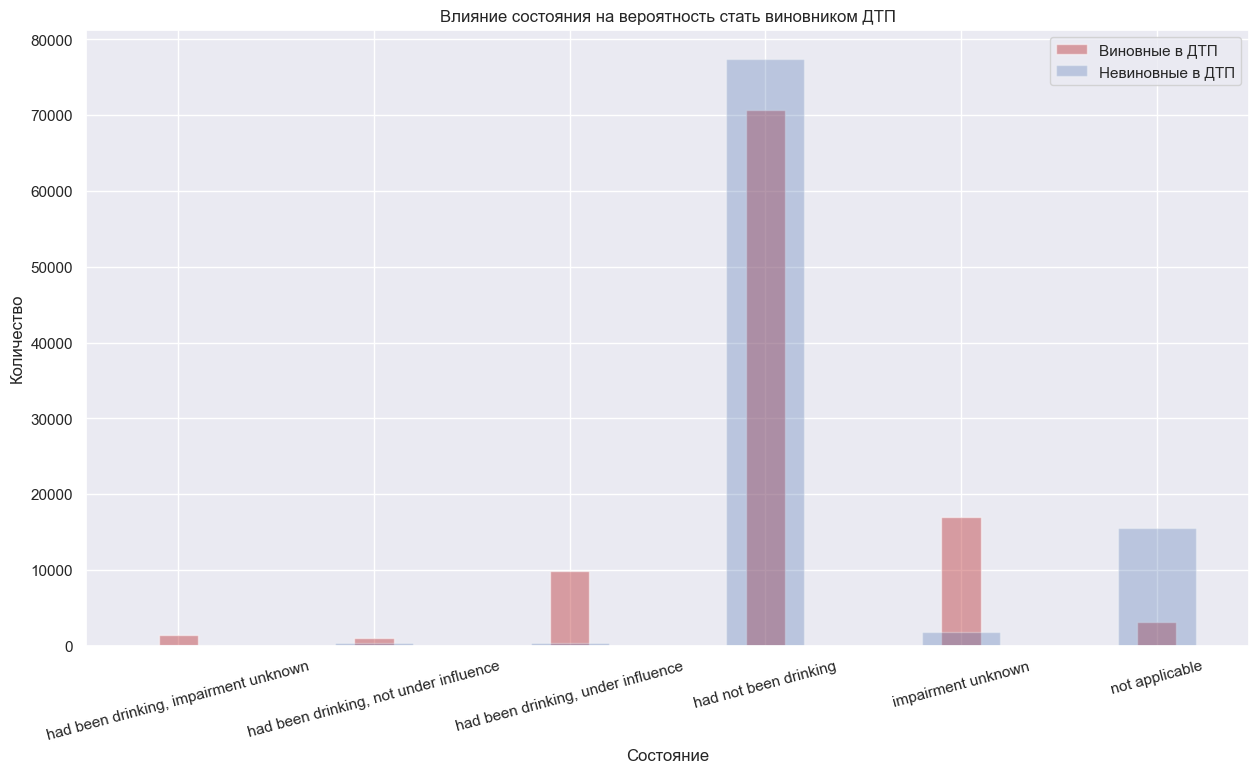

In [112]:
fig, ax = plt.subplots(figsize = (15, 8))

bar_f = plt.bar(x, y, color='r', label='Виновные в ДТП', width = 0.2, alpha=0.5)

bar_p = plt.bar(x, z, color='b', label='Невиновные в ДТП', width = 0.4, alpha=0.3)

plt.legend()
plt.xticks(rotation=15)

plt.xlabel('Состояние')
plt.ylabel('Количество')
plt.title('Влияние состояния на вероятность стать виновником ДТП')
plt.show()

**Вывод**
Самый важный фактор ДТП — уровень трезвости виновника party_sobriety

* Вероятность стать виновником ДТП повышается в следующих случаях:
    * Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)
    * Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)
    * Had Been Drinking, Under Influence (Был пьян, под влиянием)
    * Impairment Unknown (Неизвестно ухудшение)

* Предлогаем оборудовать автомобиль анализатором алкогольного опьянения. Измерение состояния при посадке сделать обязательным условием допуска за руль. А чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место.

## Выводы

**Краткое описание модели**

* Лучшая модель Catboost
* Параметры {'iterations': 2, 'max_depth': 1}
* recall 0.99

**Вывод**

* C текущим набором данных recall модели - 0.99, это значительно выше, чем при случайном поределениии виновника
* Текущее значение метрики подтверждает целесооюразность и адекватность модели.
* Для улучшения качества модели возможно стоит дополнительно собрать данные:
    * О техническом состоянии авто водителя
    * О прошлых поездках водителя
    * О штрафах за нарушении ПДД водителя